In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from plotly.subplots import  make_subplots  

import vame
from vame.util.auxiliary import read_config
from vame.analysis.community_analysis import get_adjacency_matrix
from vame.analysis.community_analysis import get_labels, compute_transition_matrices

from vame.analysis.tree_hierarchy import merge_func

import my_paths as mp

from src.loaders import get_transition_matrices

In [ ]:
_ = vame.gif(
    mp.vame_path/"config.yaml",
    pose_ref_index=[4,8],
    subtract_background=False,
    start=0, length=500, trail=5, label='motif', 
    file_format='.mp4',
    crop_size=(720,720)
)

(113,) (113, 30) (14,)


/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


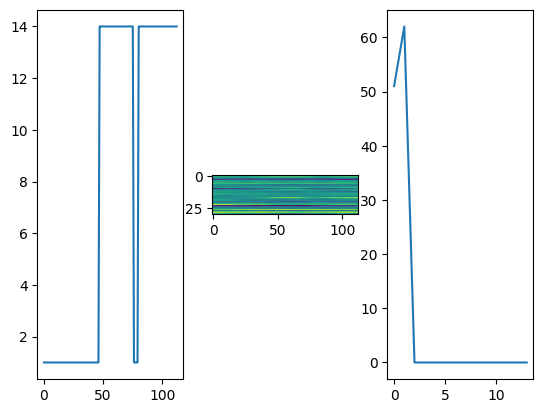

In [7]:
datum_name = "0-19-20230913124517"
estimation_path = mp.vame_path  / "results" / datum_name / "VAME" / "hmm-15"

clust_mean_path = estimation_path / f"15_km_label_{datum_name}.npy"
latent_vector_path = estimation_path / f"latent_vector_{datum_name}.npy"
motif_use_path = estimation_path / f"motif_usage_{datum_name}.npy"

clust_mean = np.load(clust_mean_path)
latent_vector = np.load(latent_vector_path)
motif_use = np.load(motif_use_path)

print(clust_mean.shape,latent_vector.shape, motif_use.shape)

fig, axes = plt.subplots(1,3)
axes[0].plot(clust_mean)
axes[1].imshow(latent_vector.T)
axes[2].plot(motif_use)

fig.show()


# Vame analysis
function already in the vame module, some of them might be usefull

Visualizing 188 data points.. 
Visualizing 113 data points.. 
Visualizing 177 data points.. 
Visualizing 165 data points.. 
Visualizing 186 data points.. 
Visualizing 171 data points.. 


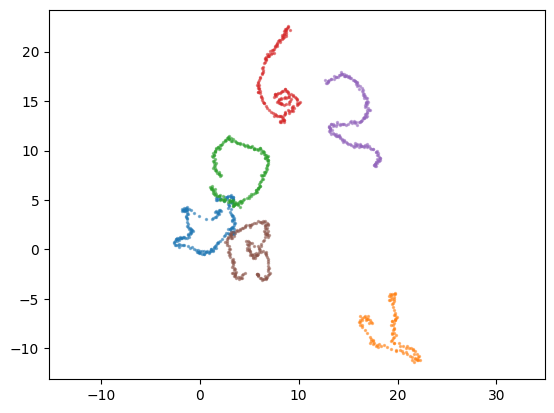

In [10]:
vame.visualization(mp.vame_path/"config.yaml")

Visualizing 188 data points.. 
Visualizing 113 data points.. 
Visualizing 177 data points.. 
Visualizing 165 data points.. 
Visualizing 186 data points.. 
Visualizing 171 data points.. 


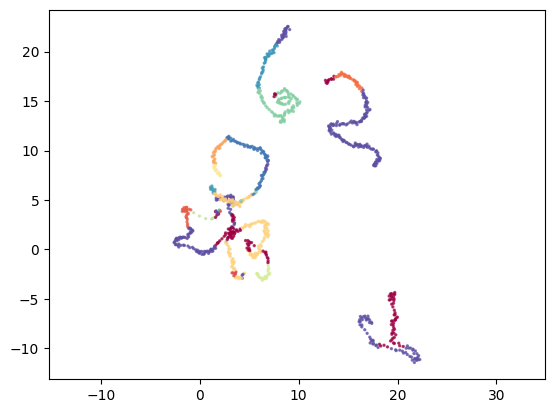

In [9]:
vame.visualization(mp.vame_path/"config.yaml", "motif")

In [50]:
out = vame.community(mp.vame_path / "config.yaml", show_umap=True, cut_tree=1)


working on 0-02-20230913122407 tree...


KeyboardInterrupt: 

In [13]:
from vame.analysis.community_analysis import umap_vis, umap_embedding

UMAP calculation for file 0-14-20230913123906
Embedding 177 data points..


/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


Embedding 177 data points..


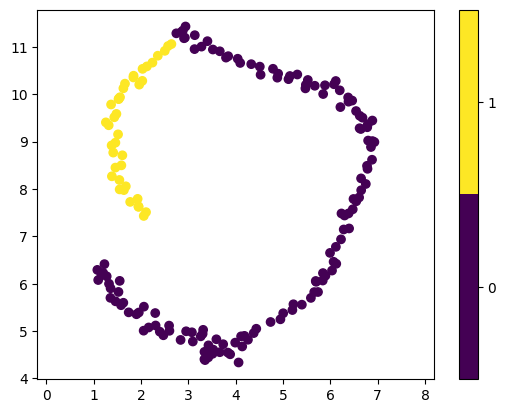

In [15]:
def _single_plot(datum):
    cfg = read_config(mp.vame_path / "config.yaml")
    n_cluster = cfg['n_cluster']
    model_name = cfg['model_name']
    parametrization = cfg['parameterization'] 
    
    path_to_file=Path(cfg['project_path'])/ "results" / datum / model_name / f"{parametrization}-{n_cluster}" / "community" / f"community_label_{datum}.npy"
    community_lables = np.load(path_to_file)
    
    embed = umap_embedding(cfg, datum, model_name, n_cluster,parametrization)
    
    # this is the function to further modify for my purpose!
    umap_vis(cfg, datum, embed, community_lables)
    
    
_single_plot("0-14-20230913123906")

# try to organize the matrices logically
for instance, transitions need to be  pooled acros videos corresponding to the same manipulation

there is two options:
1. Simply adding and re-normalizing the matrices
2. "Concatenating" label time series and then
calculating the transition matrix based on this.


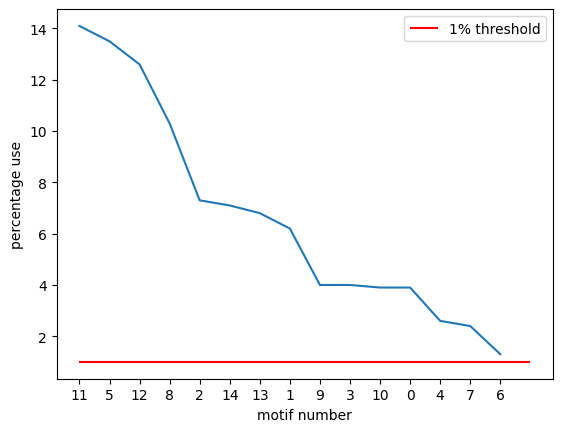

In [5]:
# histogram of most used motifs across all data
all_labels = np.concatenate(list(labels.values()))
lbl, count = np.unique(all_labels, return_counts=True)

frac_use = count / count.sum()
sorter = np.argsort(frac_use)[::-1]

_ = plt.plot(frac_use[sorter] * 100)
_ = plt.xticks(ticks=np.arange(len(lbl)), labels=lbl[sorter])
_ = plt.hlines(xmin=0, xmax=len(lbl),y=1, color="red", label="1% threshold")
_ = plt.legend()
_ = plt.xlabel("motif number")
_ = plt.ylabel("percentage use")


## arbitrary test
lests define two arbitrary groups of data to be compared as if they were left vs right

In [10]:
left_turn = set(np.asarray(data_names)[:3])
right_turn = set(np.asarray(data_names)[3:])
print(f"left: {left_turn}")
print(f"right: {right_turn}")

left: {'0-19-20230913124517', '0-14-20230913123906', '0-02-20230913122407'}
right: {'0-12-20230913123759', '0-02-20230913121608', '0-13-20230913123820'}


In [11]:
def get_common_transition_matrix(data_names):
    cfg = read_config(mp.vame_path / "config.yaml")
    labels = get_labels(
        cfg=cfg, 
        files=data_names,
        model_name = cfg['model_name'],
        n_cluster=cfg['n_cluster'],
        parameterization = cfg['parameterization'] 
    )
    # this is a little hack that adds some false transitions
    # but they are very few and its probably fine for now
    
    all_labels = np.concatenate(labels) 
        
    _, trans_mat, _ = get_adjacency_matrix(
        all_labels, cfg['n_cluster']
    )
    
    lab, count = np.unique(all_labels, return_counts=True)
    motif_use = np.zeros(cfg['n_cluster'])
    motif_use[lab] = count
    motif_use = motif_use / motif_use.sum() # normalization
    
    return trans_mat, motif_use

full_trans_mat, full_motif = get_common_transition_matrix(set.union(left_turn,right_turn))
left_trans_mat, left_motif = get_common_transition_matrix(left_turn)
right_trans_mat, right_motif = get_common_transition_matrix(right_turn)

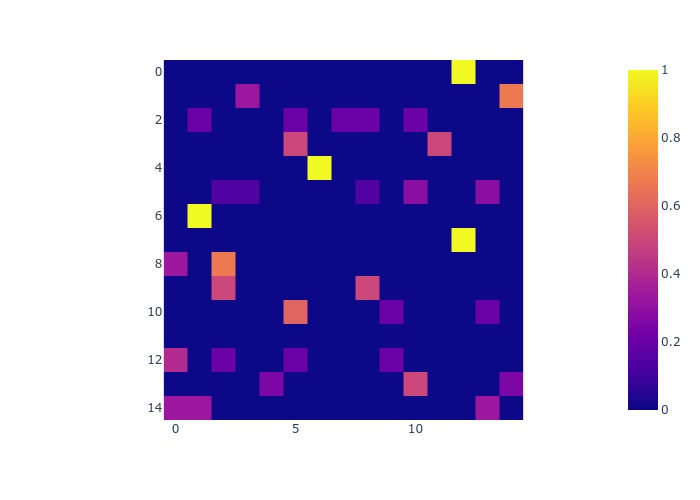

[0.039 0.062 0.073 0.04  0.026 0.135 0.013 0.024 0.103 0.04  0.039 0.141
 0.126 0.068 0.071]


In [15]:
# transition matrix pooling all data.
fig = px.imshow(full_trans_mat)
fig.show(renderer='jpeg')
print(full_motif)

In [94]:
# try sorting the matrix using the same logic than the binary tree clustering
# merge_func(left_trans_mat, left_trans_mat.shape[0], left_motif, merge_sel=1)


def sort_matrix(trans_mat, motif_use):
    n_present_motifs = np.sum(motif_use > 0)
    
    trans_redux = trans_mat.copy()
    motif_redux = motif_use.copy()
    
    node_order = list()
    tree = dict()
    
    for i in range(n_present_motifs - 1):

        nodes = merge_func(trans_redux, trans_redux.shape[0], motif_redux, 1)
        nodes = np.asarray(nodes).squeeze()
        
        # print(f"\n{nodes}")
        node_order.append(nodes)

        # asigns the sum of columns and rows to the second colum and row respectively, and zeroes the first
        trans_redux[nodes[1], :] = trans_redux[nodes, :].sum(axis=0)
        trans_redux[:, nodes[1]] = trans_redux[:, nodes].sum(axis=1)

        trans_redux[nodes[0], :] = 0
        trans_redux[:, nodes[0]] = 0

        # self transition set to zero
        trans_redux[nodes[1], nodes[1]] = 0
        
        # sums the fraction of appearance of the two merged motifs into one. and zeroes the other
        motif_redux[nodes[1]] = motif_redux[nodes].sum()
        motif_redux[nodes[0]] = 0
        
        # mini_mat = trans_redux[trans_redux.sum(axis=1)>0,:][:, trans_redux.sum(axis=1)>0,]
        # _ = plt.imshow(mini_mat)
        # _ = plt.show()
        
        # constuct a "tree" by asigning the apropiate motif idx 
        # the the current merge node 
        traversed =np.isin(nodes, list(tree.keys()))
        
        if not traversed[0] and traversed[1]:
            # merges leaf to fork and assigns to the fork key
            tree[nodes[1]] = np.concatenate(
                [nodes[0][None], tree[nodes[1]]]
            )
        elif traversed[0] and not traversed[1]:
            # merges leaf to fork and assigns to the leaf key
            tree[nodes[1]] = np.concatenate(
                [tree[nodes[0]], nodes[1][None]]
            )
            # removes merged fork
            tree.pop(nodes[0])
            # raise ValueError('this should never happen')
        elif traversed[0] and traversed[1]:
            # merging two forks and assigning to the second fork key
            tree[nodes[1]] = np.concatenate(
                [tree[nodes[0]], tree[nodes[1]]]
            )
            # removes the merged fork key
            tree.pop(nodes[0])
        elif not traversed[0] and not traversed[1]:
            # merging two leaves and asigning fork to the second leaf key
            tree[nodes[1]] = nodes
            
        # print(tree)
        
    sort_order = tree[list(tree.keys())[0]]
        
    return node_order, sort_order

nodes, sorter  = sort_matrix(full_trans_mat, full_motif)



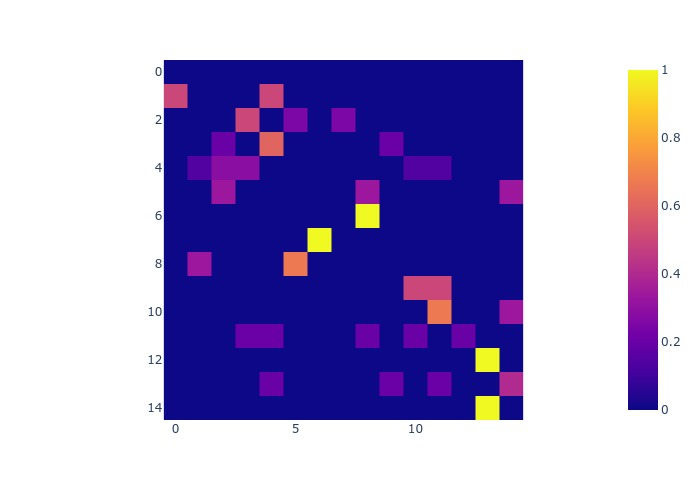

In [100]:
fig = px.imshow(full_trans_mat[sorter,:][:,sorter])
fig.show(renderer='jpeg')
# fig.show()

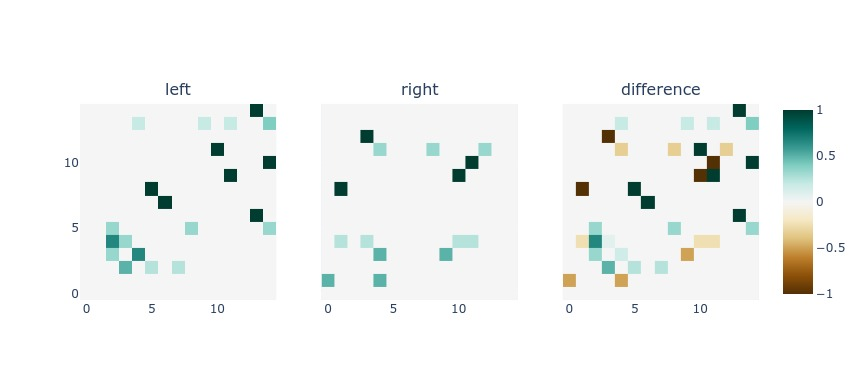

In [127]:
fig = make_subplots(
    1, 3, shared_xaxes=True, shared_yaxes=True,
                    subplot_titles=['left', 'right', 'difference']
)
matrices = [
    left_trans_mat[sorter,:][:,sorter],
    right_trans_mat[sorter,:][:,sorter],
    left_trans_mat[sorter,:][:,sorter] - right_trans_mat[sorter,:][:,sorter],
]

for ii, mat in enumerate(matrices):
    pan = px.imshow(mat)['data']
    fig.add_traces(pan, cols=[ii+1]*len(pan), rows=[1]*len(pan))
    
fig.update_layout(
    width=96*9, height=96*4,
    yaxis=dict(scaleanchor='x', scaleratio=1, constrain="domain"),
    coloraxis=dict(colorscale="BrBG")
)

fig.show(renderer='jpeg')

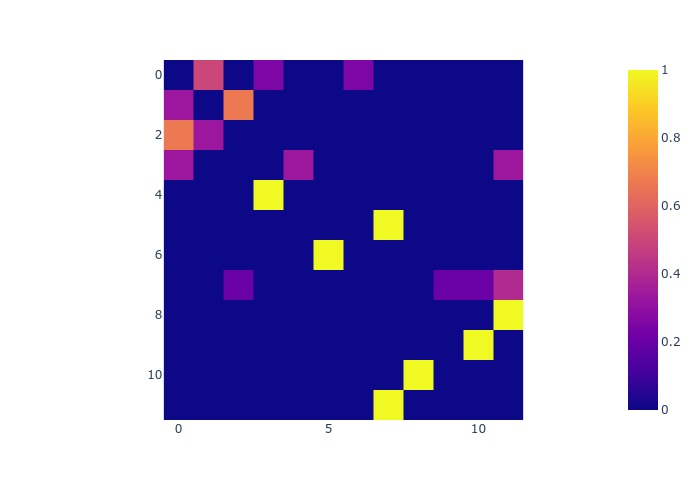

In [128]:
nodes, sorter  = sort_matrix(left_trans_mat, left_motif)
fig = px.imshow(left_trans_mat[sorter,:][:,sorter])
fig.show(renderer='jpeg')

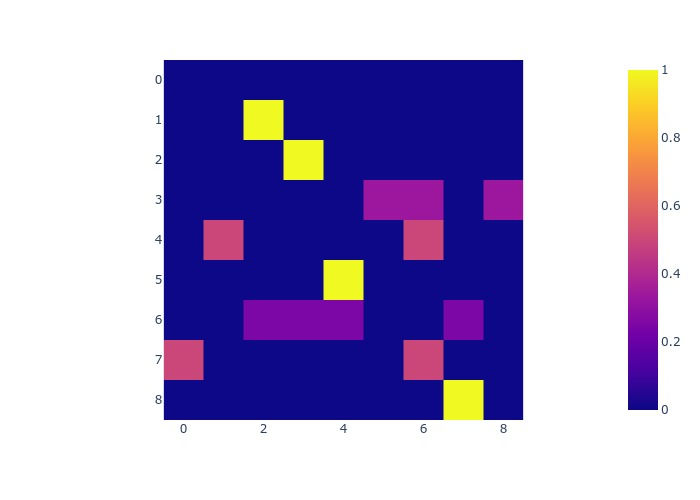

In [129]:
nodes, sorter  = sort_matrix(right_trans_mat, right_motif)
fig = px.imshow(right_trans_mat[sorter,:][:,sorter])
fig.show(renderer='jpeg')